In [7]:
# log_parser.py

import re
import pandas as pd
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def parse_general_logs(logfile, start_year=2005):
    """
    解析一般日誌文件並返回 DataFrame。

    Parameters:
        logfile (str): 日誌文件路徑。
        start_year (int): 日誌的起始年份。

    Returns:
        pd.DataFrame: 包含解析後日誌數據的 DataFrame。
    """
    # 定義日誌行的正則匹配模式
    # 假設每行類似: "Aug  4 04:03:35 combo su(pam_unix)[31009]: session opened for user cyrus by (uid=0)"
    pattern = re.compile(r'^([A-Z][a-z]{2}\s+\d+\s+\d{2}:\d{2}:\d{2})\s+(\S+)\s+([^:]+):\s*(.*)$')
    
    # 初始化當前年份和年份是否已經增加的標記
    current_year = start_year
    year_incremented = False
    
    # 存儲解析後的日誌數據
    rows = []
    
    with open(logfile, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # 跳過空行

            # 嘗試匹配整體結構
            m = pattern.match(line)
            if m:
                datetime_str = m.group(1)    # e.g. "Aug  4 04:03:35"
                hostname = m.group(2)        # e.g. "combo"
                program = m.group(3).strip() # e.g. "sshd(pam_unix)[31672]"
                message = m.group(4).strip() # e.g. "check pass; user unknown"

                # 提取月份字串以判斷年份
                month_str = datetime_str[:3]

                # 判斷是否需要切換年份（假設日誌按月份遞增，當遇到一月份時，年份增加）
                if not year_incremented and month_str == 'Jan':
                    current_year += 1
                    year_incremented = True
                elif month_str != 'Jan':
                    year_incremented = False

                # 解析日期時間，加入年份
                try:
                    log_datetime = datetime.strptime(f"{datetime_str} {current_year}", "%b %d %H:%M:%S %Y")
                except ValueError as ve:
                    print(f"日期解析錯誤: {ve}，行內容: {line}")
                    continue  # 跳過解析失敗的行

                # 清理程序名稱，移除 [pid] 和括號內的內容
                program_clean = re.sub(r'\[.*?\]', '', program)             # 移除 [數字]
                program_clean = re.sub(r'\(.*?\)', '', program_clean)      # 移除括號內內容
                program_clean = program_clean.strip()                      # 去除前後空格

                # 增加到行列表中，包含 message 和計數為1
                rows.append((log_datetime, hostname, program_clean, message, 1))
            else:
                print(f"無法解析的行: {line}")

    # 創建 DataFrame，包含 'message' 列
    df = pd.DataFrame(rows, columns=["datetime", "hostname", "program", "message", "count"])

    # 確保 'datetime' 列為 datetime 類型
    df['datetime'] = pd.to_datetime(df['datetime'])

    return df

def parse_ssh_logs(logfile, start_year=2005, access_token='YOUR_IPINFO_ACCESS_TOKEN'):
    """
    解析 SSH 日誌文件，獲取地理位置信息，並返回 DataFrame。

    Parameters:
        logfile (str): SSH 日誌文件路徑。
        start_year (int): 日誌的起始年份。
        access_token (str): ipinfo 的訪問令牌，用於地理位置查詢。

    Returns:
        pd.DataFrame: 包含解析後 SSH 日誌數據的 DataFrame。
    """
    import ipinfo  # 確保已安裝 ipinfo 庫：pip install ipinfo

    # 定義 SSH 日誌行的正則匹配模式
    # 假設每行類似: "Aug  4 07:00:29 combo sshd(pam_unix)[31672]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=arx58.internetdsl.tpnet.pl"
    log_pattern = re.compile(
        r'^(?P<datetime>[A-Z][a-z]{2}\s+\d+\s+\d{2}:\d{2}:\d{2})\s+'  # 日期時間
        r'(?P<hostname>\S+)\s+'                                   # 主機名
        r'(?P<program>sshd\(pam_unix\)\[\d+\]):\s+'              # 程式名稱和 PID
        r'authentication failure;.*'                              # 認證失敗標識
        r'rhost=(?P<rhost>[^\s]+)'                                # rhost（IP 或域名）
        r'(?:\s+user=(?P<user>\S+))?'                            # 可選的 user=欄位
    )

    # 初始化數據列表
    logs = []

    # 初始化年份
    current_year = start_year
    year_incremented = False  # 標記是否已經增加年份

    # 設置 ipinfo 的 access token
    handler = ipinfo.getHandler(access_token)

    def get_country(ip):
        """
        根據 IP 地址獲取國家名稱。
        如果 rhost 是域名或無法解析，返回 'Unknown'。
        """
        # 檢查是否為有效的 IP 地址
        ip_pattern = re.compile(r'^(?:\d{1,3}\.){3}\d{1,3}$')
        if not ip_pattern.match(ip):
            return 'Unknown'
        try:
            details = handler.getDetails(ip)
            return details.country_name if details.country_name else 'Unknown'
        except:
            return 'Unknown'

    # 讀取日誌文件並解析
    with open(logfile, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # 跳過空行

            match = log_pattern.match(line)
            if match:
                log_entry = match.groupdict()
                try:
                    # 提取月份信息
                    month_str = log_entry['datetime'][:3]

                    # 判斷是否需要切換年份
                    if not year_incremented and month_str == 'Jan':
                        current_year += 1
                        year_incremented = True
                    elif month_str != 'Jan':
                        year_incremented = False

                    # 解析日期並加入年份
                    log_entry['datetime'] = datetime.strptime(
                        f"{log_entry['datetime']} {current_year}",
                        "%b %d %H:%M:%S %Y"
                    )
                except ValueError as ve:
                    print(f"日期解析錯誤: {ve}，行內容: {line}")
                    continue  # 跳過解析失敗的行

                # 獲取國家信息
                country = get_country(log_entry['rhost'])
                log_entry['country'] = country

                logs.append(log_entry)

    # 將數據轉換為 DataFrame
    df = pd.DataFrame(logs)

    # 如果數據框為空，提示無有效數據
    if df.empty:
        print("無有效的 SSH 日誌數據可供分析。")
    else:
        # 提取日期部分
        df['date'] = df['datetime'].dt.date

    return df



無法解析的行: Sep 28 09:08:56 combo last message repeated 2 times
無法解析的行: Sep 28 09:09:19 combo exiting on signal 15
無法解析的行: Oct 25 10:06:52 combo last message repeated 14 times
無法解析的行: Oct 25 10:07:15 combo exiting on signal 15
無法解析的行: Nov 22 07:36:50 combo last message repeated 3 times
無法解析的行: Nov 22 09:31:42 combo last message repeated 2 times
無法解析的行: Nov 22 14:31:49 combo last message repeated 3 times
無法解析的行: Nov 22 14:32:21 combo last message repeated 3 times
無法解析的行: Nov 22 17:26:15 combo last message repeated 2 times
無法解析的行: Nov 23 08:16:52 combo last message repeated 2 times
無法解析的行: Nov 23 13:41:37 combo last message repeated 2 times
無法解析的行: Nov 23 14:41:27 combo last message repeated 3 times
無法解析的行: Nov 23 14:46:09 combo last message repeated 2 times
無法解析的行: Nov 23 21:36:40 combo last message repeated 3 times
無法解析的行: Nov 29 04:43:12 combo last message repeated 3 times
無法解析的行: Dec  6 12:21:26 combo exiting on signal 15
無法解析的行: Dec  9 09:43:13 combo exiting on signal 15
無法解析的行: Jan 26 

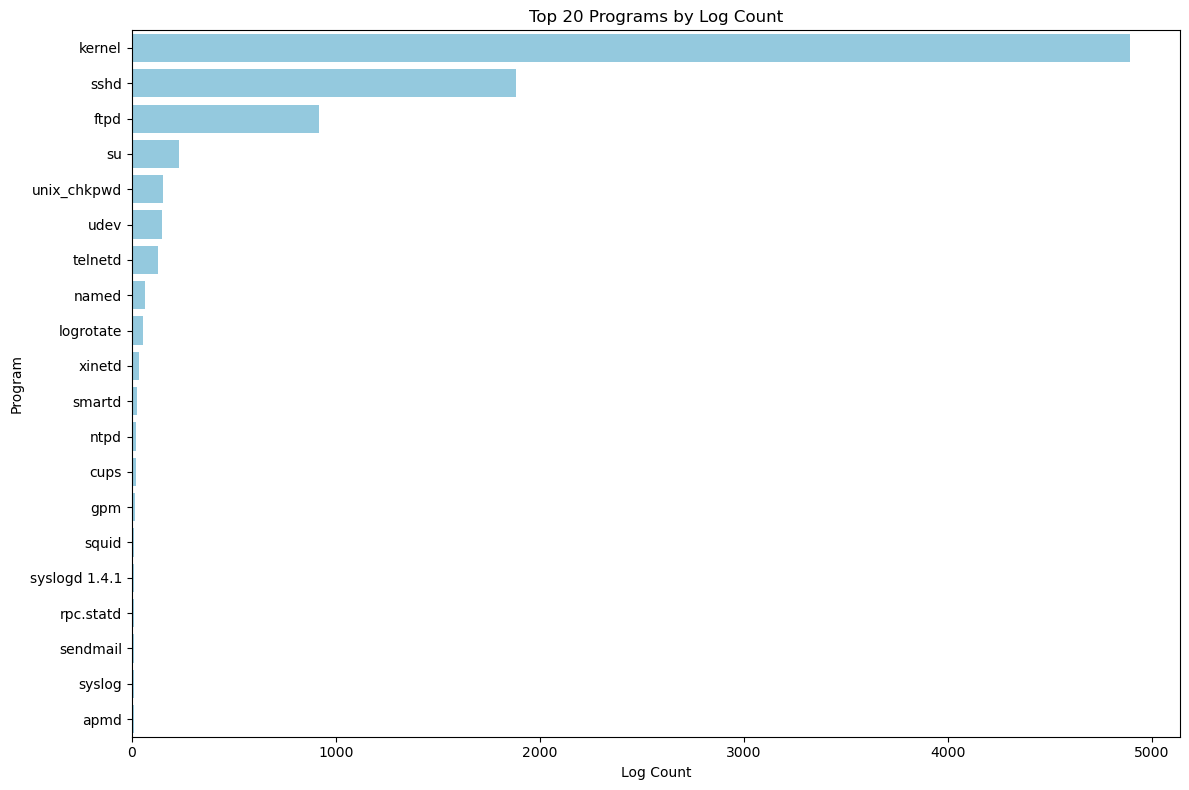

柱狀圖已保存為 'output\images\program_summary_top20.png'。


In [12]:

def ensure_directories():
    """
    確保 output/csv 和 output/images 資料夾存在，若不存在則創建。
    """
    os.makedirs(os.path.join('output', 'csv'), exist_ok=True)
    os.makedirs(os.path.join('output', 'images'), exist_ok=True)


def main():
    # 確保資料夾存在
    ensure_directories()

    # 日誌文件名稱
    logfile = 'Linux.log'  # 修改為您的日誌文件路徑

    # 解析日誌
    df = parse_general_logs(logfile)

    # 1. 讓使用者選擇要查看的天數，默認為全部日誌
    while True:
        try:
            days_input = input("請輸入要查看的天數（留空表示查看所有日誌）：").strip()
            if days_input == '':
                days_choice = None
                break
            else:
                days_choice = int(days_input)
                if days_choice > 0:
                    break
                else:
                    print("請輸入一個正整數。")
        except ValueError:
            print("無效輸入，請輸入數字。")

    # 2. 根據選擇的天數篩選日誌
    if days_choice is not None:
        latest_date = df['datetime'].max()
        start_date = latest_date - pd.Timedelta(days=days_choice)
        print(f"\n篩選日期範圍：從 {start_date.strftime('%Y-%m-%d')} 到 {latest_date.strftime('%Y-%m-%d')}\n")
        filtered_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= latest_date)]
    else:
        filtered_df = df.copy()

    # 3. 彙總在所選時間範圍內每個程式的日誌出現次數
    df_summary = filtered_df.groupby('program')['count'].sum().reset_index().sort_values(by='count', ascending=False)

    # 顯示彙總結果
    #print("各程式的出現次數：")
    #print(df_summary)

    # 4. 列出所有唯一的程式名稱並讓使用者選擇程式
    unique_programs = df_summary['program'].tolist()
    print("\n可用的程式列表：")
    for idx, prog in enumerate(unique_programs, 1):
        print(f"{idx}. {prog} - {df_summary.iloc[idx-1]['count']} 次")

    # 5. 讓使用者選擇要查看的程式
    while True:
        try:
            prog_choice = input(f"\n請輸入要查看的程式編號（1-{len(unique_programs)}，留空表示顯示所有日誌）：").strip()
            if prog_choice == '':
                print("顯示所有程式的日誌：\n")
                selected_logs = filtered_df.copy()
                break
            prog_choice = int(prog_choice)
            if 1 <= prog_choice <= len(unique_programs):
                selected_program = unique_programs[prog_choice - 1]
                print(f"\n顯示程式 '{selected_program}' 的日誌：\n")
                selected_logs = filtered_df[filtered_df['program'] == selected_program]
                break
            else:
                print(f"請輸入一個介於 1 和 {len(unique_programs)} 之間的數字。")
        except ValueError:
            print("無效輸入，請輸入數字。")

    # 6. 顯示選定程式的日誌
    if not selected_logs.empty:
        # 格式化顯示
        for index, row in selected_logs.iterrows():
            print(f"{row['datetime'].strftime('%Y-%m-%d %H:%M:%S')} {row['hostname']} {row['program']}: {row['message']}")
    else:
        print("沒有找到符合條件的日誌。")

    # 可選：保存篩選後的日誌到 CSV
    save_choice = input("\n是否將選定的日誌保存到 'output/csv/selected_program_logs.csv'？（y/n）：").strip().lower()
    if save_choice == 'y':
        output_csv_path = os.path.join('output', 'csv', 'selected_program_logs.csv')
        selected_logs.to_csv(output_csv_path, index=False, encoding='utf-8')
        print(f"選定的日誌已保存到 '{output_csv_path}'。")

    # 可選：視覺化所有程式的出現次數
    visualize_choice = input("\n是否生成所有程式出現次數的柱狀圖並保存到 'output/images'？（y/n）：").strip().lower()
    if visualize_choice == 'y':
        plt.figure(figsize=(12, 8))

        # 生成柱狀圖，顯示前 20 個程式
        sns.barplot(x='count', y='program', data=df_summary.head(20), color='skyblue')  # 顯示前 20 個，使用單一顏色

        # 設置英文標題和標籤
        plt.title('Top 20 Programs by Log Count')
        plt.xlabel('Log Count')
        plt.ylabel('Program')

        plt.tight_layout()

        # 保存圖表為圖片
        images_path = os.path.join('output', 'images', 'program_summary_top20.png')
        plt.savefig(images_path)  # 保存圖表為圖片
        plt.show()
        print(f"柱狀圖已保存為 '{images_path}'。")


if __name__ == "__main__":
    main()

In [13]:
# ssh_log_analysis.py

import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

def main():
    # 日誌文件名稱
    logfile = 'Linux.log'  # 修改為您的 SSH 日誌文件路徑

    # 設定 ipinfo 的 access token
    access_token = '87957b8996885a'  # 替換為您的 ipinfo access token

    # 解析 SSH 日誌
    df = parse_ssh_logs(logfile, access_token=access_token)

    # 如果 DataFrame 為空，退出
    if df.empty:
        print("無有效的 SSH 日誌數據可供分析。")
        return

    # 提取日期部分
    df['date'] = df['datetime'].dt.date

    # 設定分析範圍：最近兩週（14天）
    end_date = df['date'].max()
    start_date = end_date - timedelta(days=90)  # 包含今天，共14天

    # 過濾範圍內的數據
    df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    if df_filtered.empty:
        print("在指定的兩週範圍內未找到有效的 SSH 登錄嘗試記錄。")
        return

    # 1. 每日登錄失敗次數統計
    daily_stats = df_filtered['date'].value_counts().sort_index()

    # 2. 按來源 IP 統計嘗試次數
    ip_stats = df_filtered['rhost'].value_counts().reset_index()
    ip_stats.columns = ['IP Address', 'Attempt Count']

    # 3. 按使用者名稱統計嘗試次數
    user_stats = df_filtered['user'].fillna('Unknown').value_counts().reset_index()
    user_stats.columns = ['Username', 'Attempt Count']

    # 4. 時間分佈分析（按小時）
    df_filtered['hour'] = df_filtered['datetime'].dt.hour
    time_stats = df_filtered['hour'].value_counts().sort_index()

    # 5. 來源國家地理位置分析
    country_stats = df_filtered['country'].value_counts().reset_index()
    country_stats.columns = ['Country', 'Attempt Count']

    # 6. 輸出分析結果
    print("=== 最近兩週每日登錄失敗次數 ===")
    print(daily_stats.to_string())

    print("\n=== 來源 IP 統計（前10名） ===")
    print(ip_stats.head(10).to_string(index=False))

    print("\n=== 使用者名稱統計（前10名） ===")
    print(user_stats.head(10).to_string(index=False))

    print("\n=== 攻擊時間分佈（按小時） ===")
    print(time_stats.to_string())

    print("\n=== 來源國家統計（前10名） ===")
    print(country_stats.head(10).to_string(index=False))

    # 創建資料夾結構
    output_folder = 'output-ssh'
    csv_folder = os.path.join(output_folder, 'csv')
    img_folder = os.path.join(output_folder, 'images')

    # 確保資料夾存在
    os.makedirs(csv_folder, exist_ok=True)
    os.makedirs(img_folder, exist_ok=True)

    # 7.1 每日登錄失敗次數折線圖
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=daily_stats.index, y=daily_stats.values, marker='o')
    plt.title('Daily SSH Login Failures in the Last Two Weeks')
    plt.xlabel('Date')
    plt.ylabel('Number of Failures')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, 'daily_login_failures.png'))
    plt.close()

    # 7.2 來源 IP 前10名柱狀圖
    plt.figure(figsize=(12, 6))
    sns.barplot(x='IP Address', y='Attempt Count', data=ip_stats.head(10))
    plt.title('Top 10 IP Addresses by SSH Login Failures')
    plt.xlabel('IP Address')
    plt.ylabel('Number of Failures')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, 'top10_ip_failures.png'))
    plt.close()

    # 7.3 使用者名稱前10名柱狀圖
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Username', y='Attempt Count', data=user_stats.head(10))
    plt.title('Top 10 Usernames by SSH Login Failures')
    plt.xlabel('Username')
    plt.ylabel('Number of Failures')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, 'top10_user_failures.png'))
    plt.close()

    # 7.4 時間分佈直方圖
    plt.figure(figsize=(12, 6))
    sns.barplot(x=time_stats.index, y=time_stats.values, color='coral')
    plt.title('Hourly Distribution of SSH Login Failures')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Failures')
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, 'hourly_login_failures.png'))
    plt.close()

    # 7.5 來源國家前10名柱狀圖
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Country', y='Attempt Count', data=country_stats.head(10))
    plt.title('Top 10 Countries by SSH Login Failures')
    plt.xlabel('Country')
    plt.ylabel('Number of Failures')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, 'top10_countries_failures.png'))
    plt.close()

    # 8. 將分析結果保存到文件
    daily_stats.to_csv(os.path.join(csv_folder, 'daily_login_failures.csv'), index=True, header=["Number of Failures"])
    ip_stats.to_csv(os.path.join(csv_folder, 'ip_failures.csv'), index=False)
    user_stats.to_csv(os.path.join(csv_folder, 'user_failures.csv'), index=False)
    time_stats.to_csv(os.path.join(csv_folder, 'hourly_failures.csv'), index=True, header=["Number of Failures"])
    country_stats.to_csv(os.path.join(csv_folder, 'country_failures.csv'), index=False)

    print("\n分析結果已保存到以下文件：")
    print(f"- {os.path.join(csv_folder, 'daily_login_failures.csv')}")
    print(f"- {os.path.join(csv_folder, 'ip_failures.csv')}")
    print(f"- {os.path.join(csv_folder, 'user_failures.csv')}")
    print(f"- {os.path.join(csv_folder, 'hourly_failures.csv')}")
    print(f"- {os.path.join(csv_folder, 'country_failures.csv')}")
    print(f"- {os.path.join(img_folder, 'daily_login_failures.png')}")
    print(f"- {os.path.join(img_folder, 'top10_ip_failures.png')}")
    print(f"- {os.path.join(img_folder, 'top10_user_failures.png')}")
    print(f"- {os.path.join(img_folder, 'hourly_login_failures.png')}")
    print(f"- {os.path.join(img_folder, 'top10_countries_failures.png')}")

if __name__ == "__main__":
    main()


C:\Users\ray03\AppData\Local\Temp\ipykernel_27928\3003129220.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hour'] = df_filtered['datetime'].dt.hour


=== 最近兩週每日登錄失敗次數 ===
date
2005-11-30     10
2005-12-01      3
2005-12-02     12
2005-12-03     10
2005-12-05     20
2005-12-07     10
2005-12-08      9
2005-12-09     10
2006-01-07     10
2006-01-08      1
2006-01-09      4
2006-01-10     26
2006-01-11     15
2006-01-12     62
2006-01-13     38
2006-01-14     65
2006-01-15     40
2006-01-16     67
2006-01-17     33
2006-01-18     37
2006-01-19     49
2006-01-20     47
2006-01-21     20
2006-01-22     27
2006-01-23    146
2006-01-24     34
2006-01-26      4
2006-01-27     22
2006-01-28     11
2006-01-29     11
2006-01-30     43
2006-01-31     64
2006-02-01     50
2006-02-02     24
2006-02-03      2
2006-02-05     27
2006-02-06     24
2006-02-07     18
2006-02-08     29
2006-02-09     19
2006-02-10     40
2006-02-11     10
2006-02-12     15
2006-02-13     20
2006-02-14     10
2006-02-15     37
2006-02-16     32
2006-02-17     20
2006-02-18     27
2006-02-19     30
2006-02-20     26
2006-02-22     20
2006-02-23     26
2006-02-24     60
20